Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
import pandas as pd
import winsound
import time
import itertools

In [2]:
pickle_file = 'D:/Libraries/Documents/Tensorflow/notMNIST_data/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (300000, 28, 28) (300000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (300000, 28, 28, 1) (300000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [8]:
batch_size = 64
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')#stride of 2
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')#stride of 2
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])#flatten the image for the FC layers
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [49]:
num_steps = 10001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.620249
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 500: 0.340294
Minibatch accuracy: 89.1%
Validation accuracy: 83.4%
Minibatch loss at step 1000: 0.455957
Minibatch accuracy: 89.1%
Validation accuracy: 85.5%
Minibatch loss at step 1500: 0.699348
Minibatch accuracy: 82.8%
Validation accuracy: 86.9%
Minibatch loss at step 2000: 0.404987
Minibatch accuracy: 87.5%
Validation accuracy: 86.6%
Minibatch loss at step 2500: 0.153669
Minibatch accuracy: 96.9%
Validation accuracy: 87.6%
Minibatch loss at step 3000: 0.316075
Minibatch accuracy: 89.1%
Validation accuracy: 87.8%
Minibatch loss at step 3500: 0.339815
Minibatch accuracy: 90.6%
Validation accuracy: 88.2%
Minibatch loss at step 4000: 0.472506
Minibatch accuracy: 82.8%
Validation accuracy: 88.3%
Minibatch loss at step 4500: 0.295269
Minibatch accuracy: 92.2%
Validation accuracy: 88.4%
Minibatch loss at step 5000: 0.295001
Minibatch accuracy: 95.3%
Validation accuracy

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [9]:
batch_size = 64
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))#why is this initialized to 1 and the last one to 0?
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')#stride of 1
    hidden = tf.nn.relu(conv + layer1_biases)
    pooled = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    print(pooled.get_shape().as_list())
    conv = tf.nn.conv2d(pooled, layer2_weights, [1, 1, 1, 1], padding='SAME')#stride of 1
    hidden = tf.nn.relu(conv + layer2_biases)
    pooled = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    shape = pooled.get_shape().as_list()
    print(shape)
    reshape = tf.reshape(pooled, [shape[0], shape[1] * shape[2] * shape[3]])#flatten the image for the FC layers
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

[64, 14, 14, 16]
[64, 7, 7, 16]
[10000, 14, 14, 16]
[10000, 7, 7, 16]
[10000, 14, 14, 16]
[10000, 7, 7, 16]


In [51]:
num_steps = 10001
test_preds = 0

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  test_preds = test_prediction.eval()
  print('Test accuracy: %.1f%%' % accuracy(test_preds, test_labels))


Initialized
Minibatch loss at step 0: 3.226361
Minibatch accuracy: 10.9%
Validation accuracy: 9.1%
Minibatch loss at step 1000: 0.461887
Minibatch accuracy: 85.9%
Validation accuracy: 85.5%
Minibatch loss at step 2000: 0.380003
Minibatch accuracy: 87.5%
Validation accuracy: 86.7%
Minibatch loss at step 3000: 0.319473
Minibatch accuracy: 89.1%
Validation accuracy: 88.0%
Minibatch loss at step 4000: 0.556612
Minibatch accuracy: 84.4%
Validation accuracy: 88.2%
Minibatch loss at step 5000: 0.311766
Minibatch accuracy: 92.2%
Validation accuracy: 88.7%
Minibatch loss at step 6000: 0.402862
Minibatch accuracy: 90.6%
Validation accuracy: 88.9%
Minibatch loss at step 7000: 0.198159
Minibatch accuracy: 95.3%
Validation accuracy: 89.3%
Minibatch loss at step 8000: 0.509191
Minibatch accuracy: 85.9%
Validation accuracy: 89.4%
Minibatch loss at step 9000: 0.285312
Minibatch accuracy: 89.1%
Validation accuracy: 89.3%
Minibatch loss at step 10000: 0.298528
Minibatch accuracy: 90.6%
Validation accura

Displaying some of the images we got wrong. We can see that the dataset has some incorrect labels. However, some of the images are easy to identify by eye and the classifier still incorrectly labels them. Generally they are ones where there are rotated images, or very thin or thick lines. The classifier does not use the topology of the image as well as the eye does. It also does not realize when the font is using negative space to create a letter

Predicted:  G
Actual:  B


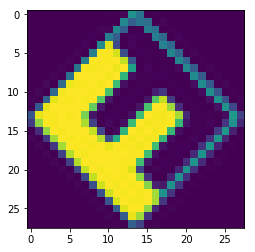

Predicted:  G
Actual:  J


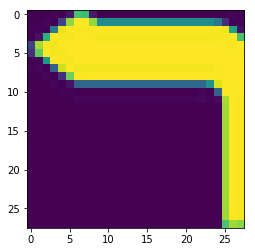

Predicted:  J
Actual:  H


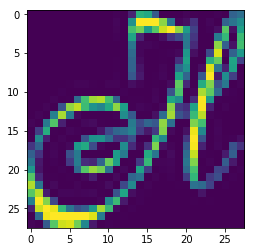

Predicted:  H
Actual:  A


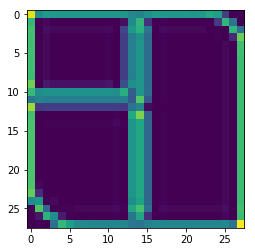

Predicted:  B
Actual:  C


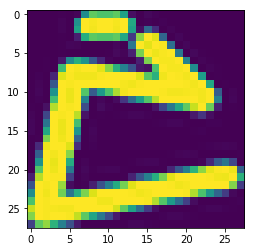

Predicted:  E
Actual:  C


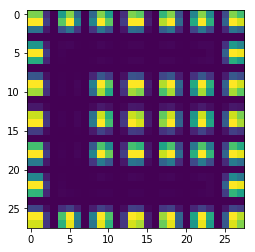

Predicted:  G
Actual:  B


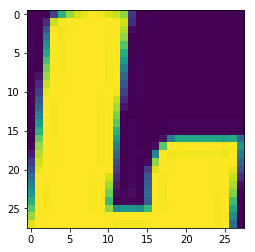

Predicted:  B
Actual:  F


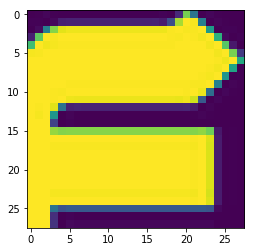

Predicted:  H
Actual:  A


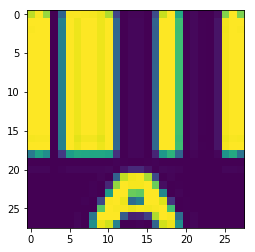

Predicted:  G
Actual:  I


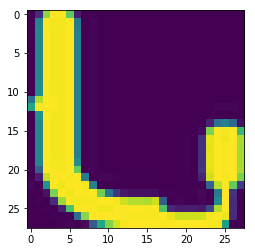

In [52]:
test_preds_num = np.argmax(test_preds, axis=1)
test_labels_num = np.argmax(test_labels, axis=1)
accuracy_array = test_preds_num == test_labels_num
errors = np.where(accuracy_array == False)
error_images = np.squeeze(test_dataset[errors,:,:,:])
error_preds = test_preds_num[errors]
error_labels = test_labels_num[errors]

num_errors_shown= 10
for i in range(num_errors_shown):
  print("Predicted: ",chr(error_preds[i]+65))
  print("Actual: ", chr(error_labels[i]+65))
  plt.imshow(error_images[i])
  plt.show()

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

In [6]:
batch_size = 64
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))#why is this initialized to 1 and the last one to 0?
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')#stride of 1
    hidden = tf.nn.relu(conv + layer1_biases)
    pooled = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    conv = tf.nn.conv2d(pooled, layer2_weights, [1, 1, 1, 1], padding='SAME')#stride of 1
    hidden = tf.nn.relu(conv + layer2_biases)
    pooled = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    shape = pooled.get_shape().as_list()
    reshape = tf.reshape(pooled, [shape[0], shape[1] * shape[2] * shape[3]])#flatten the image for the FC layers
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [8]:
num_steps = 5001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  t1= time.time()
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  t2 = time.time()
  print("Time: ", t2-t1)
  test_preds = test_prediction.eval()
  print('Test accuracy: %.1f%%' % accuracy(test_preds, test_labels))


Initialized
Minibatch loss at step 0: 4.576417
Minibatch accuracy: 12.5%
Validation accuracy: 10.0%
Minibatch loss at step 1000: 0.473701
Minibatch accuracy: 85.9%
Validation accuracy: 85.7%
Minibatch loss at step 2000: 0.412366
Minibatch accuracy: 85.9%
Validation accuracy: 87.0%
Minibatch loss at step 3000: 0.367866
Minibatch accuracy: 89.1%
Validation accuracy: 87.8%
Minibatch loss at step 4000: 0.452540
Minibatch accuracy: 87.5%
Validation accuracy: 88.3%
Minibatch loss at step 5000: 0.236111
Minibatch accuracy: 96.9%
Validation accuracy: 88.9%
Time:  78.43014478683472
Test accuracy: 94.7%


In [6]:
trunc_valid_X = valid_dataset[:1000]
trunc_test_X = test_dataset[:1000]
trunc_valid_y = valid_labels[:1000]
trunc_test_y = test_labels[:1000]

In [7]:
batch_size= 16
patch_sizes_1 = [5,3]
patch_sizes_2 = [5,3]
depths = [16,32]#
num_hiddens = [32,64]#
num_steps = 10001
learning_rates = [.05,.01,.005]#

cols = ['patch size 1', 'patch size 2', 'depth',
                                 'num_hidden','learning_rate', 'training time',
                                 'validation accuracy', 'testing accuracy']
results = {}
for col in cols:
  results[col] =[]

for patch_size_1, patch_size_2, depth, num_hidden, learning_rate in itertools.product(patch_sizes_1, 
                    patch_sizes_2, depths,num_hiddens, learning_rates):
  results['patch size 1'].append(patch_size_1)
  results['patch size 2'].append(patch_size_2)
  results['depth'].append(depth)
  results['num_hidden'].append(num_hidden)
  results['learning_rate'].append(learning_rate)
  
  graph = tf.Graph()
  with graph.as_default():
    # Input data.
    tf_train_dataset = tf.placeholder(
      tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(trunc_valid_X)
    tf_test_dataset = tf.constant(trunc_test_X)
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
        [patch_size_1, patch_size_1, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
        [patch_size_2, patch_size_2, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))#why is this initialized to 1 and the last one to 0?
    layer3_weights = tf.Variable(tf.truncated_normal(
        [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    # Model.
    def model(data):
      conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')#stride of 1
      hidden = tf.nn.relu(conv + layer1_biases)
      pooled = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
      conv = tf.nn.conv2d(pooled, layer2_weights, [1, 1, 1, 1], padding='SAME')#stride of 1
      hidden = tf.nn.relu(conv + layer2_biases)
      pooled = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
      shape = pooled.get_shape().as_list()
      reshape = tf.reshape(pooled, [shape[0], shape[1] * shape[2] * shape[3]])#flatten the image for the FC layers
      hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
      return tf.matmul(hidden, layer4_weights) + layer4_biases
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

  with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    t1= time.time()
    validation_accuracies = []
    for step in range(num_steps):
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
      if (step % 1000 == 0):
        validation_accuracies.append(accuracy(valid_prediction.eval(), trunc_valid_y))
    t2 = time.time()
    results['training time'].append(t2-t1)
    results['validation accuracy'].append(validation_accuracies)
    results['testing accuracy'].append(accuracy(test_prediction.eval(), trunc_test_y))

    
winsound.Beep(500,1000)
results = pd.DataFrame(results)


Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized


In [13]:
sorted_results = results.sort_values('testing accuracy', inplace = False, ascending= False)
sorted_results

,depth,learning_rate,num_hidden,patch size 1,patch size 2,testing accuracy,training time,validation accuracy
15,16,0.050,64,5,3,94.9,48.658773,"[12.0, 82.9, 85.4, 85.4, 86.2, 87.1, 87.4, 87...."
3,16,0.050,64,5,5,94.7,52.067096,"[8.9, 84.0, 85.2, 86.0, 87.3, 87.1, 87.9, 87.8..."
6,32,0.050,32,5,5,94.7,77.880677,"[11.8, 83.8, 85.8, 85.8, 87.4, 86.6, 87.8, 87...."
12,16,0.050,32,5,3,94.4,48.978811,"[10.9, 83.3, 83.8, 85.3, 85.1, 86.1, 86.4, 86...."
27,16,0.050,64,3,5,94.4,50.998809,"[12.0, 82.8, 85.4, 85.0, 85.6, 85.7, 87.3, 87...."
9,32,0.050,64,5,5,94.4,78.389090,"[9.9, 83.6, 85.9, 84.9, 86.4, 87.5, 87.0, 87.7..."
21,32,0.050,64,5,3,94.3,71.399626,"[11.4, 82.6, 84.6, 85.3, 86.3, 86.1, 87.0, 87...."
33,32,0.050,64,3,5,93.9,77.253256,"[10.0, 81.7, 85.3, 85.5, 86.3, 86.7, 86.2, 86...."
0,16,0.050,32,5,5,93.8,51.857357,"[11.2, 84.0, 85.8, 86.4, 86.9, 86.9, 88.1, 88...."
7,32,0.010,32,5,5,93.8,77.595005,"[11.0, 81.5, 82.9, 83.8, 84.7, 84.5, 85.0, 84...."
